In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import lmpsetup
import hmdsetup

import lmp
import hmd

import matplotlib.gridspec as gridspec
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import analysis

import scipy.constants as cnt

import shutil
import os
import mdtraj as md
import statsmodels.tsa.stattools
import MDAnalysis.analysis as mda
import scipy
from matplotlib.lines import Line2D


from style_vars import *
plt.style.use('default')
plt.style.use('style.mplstyle')

hps_lines = [Line2D([0], [0], color='black', ls='--'),
                Line2D([0], [0], color='black')]

wt_d4_lines = [Line2D([0], [0], color=C_W),
                Line2D([0], [0], color=C_4)]

### Contact maps - SINGLE CHAIN

In [58]:
# 1.0
wt_1 = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/0.8/WT', low_mem=True, every=100)
print(wt_1.structures[0].xyz.max())
wt_cmaps = wt_1.intra_distance_map(normed=False, contacts=True).mean(axis=1)

d4_1 = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/0.8/D4', low_mem=True, every=100)
d4_cmaps = d4_1.intra_distance_map(normed=False, contacts=True).mean(axis=1)

> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 100 for a total of [1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001] to avoid strong correlations
290.28802
> Run Completed at 100.00% for CPEB4_D4. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 100 for a total of [1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001] to avoid strong correlations


**BY POS**

/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


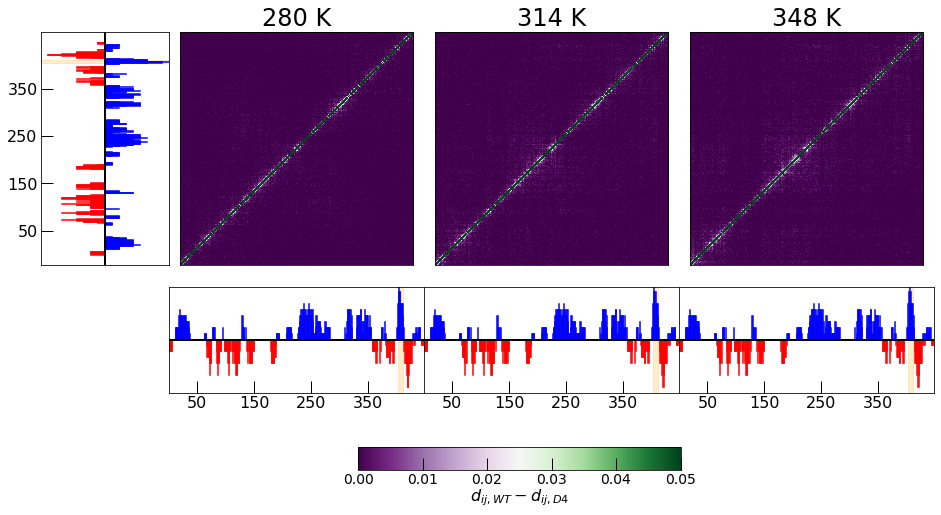

In [65]:
# from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig = plt.figure(figsize=(16, 16))

grid = plt.GridSpec(7, 7, wspace=0., hspace=0.2)
viridis = plt.get_cmap('viridis', 256)
ds = viridis(np.linspace(0, 1, 256))

ds[:]=0
ds[:,3] = 1
ds[:64,1]=np.linspace(0.3,1,64)
ds[:64,0]=np.linspace(0,0.5,64)
ds[:64,2]=np.linspace(0,0.5,64)
ds[64:128,1]=1
ds[64:128,0]=np.linspace(0.5,1,64)
ds[64:128,2]=np.linspace(0.5,1,64)

ds[128:192,0]=1
ds[128:192,1]=np.linspace(1,0,64)
ds[128:192,2]=np.linspace(1,0,64)
ds[192:256,0]=np.linspace(1,0.3,64)

ds = np.flip(ds,axis=0)
newcmp = ListedColormap(ds)

for i, t in enumerate([0,2,4]):
    ax = plt.subplot(grid[:2, (t+1):(t+3)])
    s = wt_cmaps.copy()
    s = np.delete(s, np.arange(402, 410), axis=2)
    s = np.delete(s, np.arange(402, 410), axis=1)
#     img = ax.imshow(s[t,:,:]-d4_cmaps[t,:,:], vmin=-10, cmap='PRGn', vmax=10)
    img = ax.imshow(d4_cmaps[t,:,:], cmap='PRGn', vmax=0.05)
    ax.set_title(f"{wt_1.temperatures[t]:.0f} K")
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])

win, plus, minus = wt_1.get_charge_seq()

with open('/home/adria/scripts/data/sequences/CPEB4.seq') as wt:
    wt_seq = wt.readlines()[0]
with open('/home/adria/scripts/data/sequences/CPEB4_D4.seq') as d4:
    d4_seq = d4.readlines()[0]
with open('/home/adria/scripts/data/sequences/12D_CPEB4_D4.seq') as d12:
    d12_seq = d12.readlines()[0]
with open('/home/adria/scripts/data/sequences/7D_CPEB4.seq') as d7:
    d7_seq = d7.readlines()[0]
    
for i, j in enumerate([0,2,4]):
    ax = plt.subplot(grid[2:3, (j+1):(j+3)])
    for i,p in enumerate(plus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='blue')
    for i,p in enumerate(minus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='red')
    ax.axvspan(403,411, alpha=0.2, color='orange')
    ax.axhline(0, color='black', lw=2)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(-5,450)
    ax.set_xlim(0,448)
#     ax.set_xlabel("")
#     ax.set_xlabel("Residue", fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([50,150,250,350])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
ax = plt.subplot(grid[:2, :1])
for i,p in enumerate(plus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='blue')
for i,p in enumerate(minus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='red')
ax.axhspan(403,411, alpha=0.2, color='orange')
ax.axvline(0.5, color='black', lw=2)
# ax.set_ylabel("Residue", fontsize=16)
ax.set_yticks([50,150,250,350])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
    
# plt.subplot(grid[2:3, 1:3]).set_ylabel("$\langle q⟩_9$")
# plt.subplot(grid[:2, :1]).set_xlabel("$\langle q⟩_9$")
fig.tight_layout()

cbar_ax = fig.add_axes([0.4, 0.50, 0.28, 0.02])
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$d_{ij, WT}-d_{ij, D4}$', rotation=0, fontsize=16, labelpad=0)

**BY TYPE**

{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}
{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}
{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}
{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}


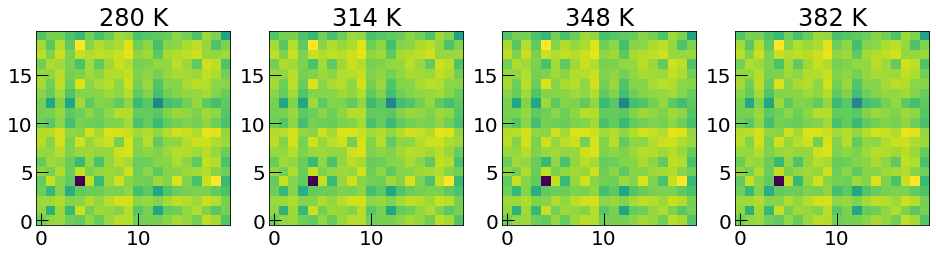

In [7]:
fig, ax = plt.subplots(1,4,figsize=(16,16))
for i, t in enumerate([0,2,4,6]):
#     ax = plt.subplot(grid[:2, (i*2+1):((i+1)*2+1)])
    aa_map = wt_1.map_to_residue(contacts=wt_cmaps[t,:,:], normed=True)
    img = ax[i].imshow(aa_map)
    ax[i].set_title(f"{wt_1.temperatures[t]:.0f} K")
    ax[i].invert_yaxis()
#     ax.set_xticks([])
#     ax.set_yticks([])

In [ ]:
# from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


fig = plt.figure(figsize=(16, 16))

grid = plt.GridSpec(9, 9, wspace=0., hspace=0.)
viridis = cm.get_cmap('viridis', 256)
ds = viridis(np.linspace(0, 1, 256))

ds[:]=0
ds[:,3] = 1
ds[:64,1]=np.linspace(0.3,1,64)
ds[:64,0]=np.linspace(0,0.5,64)
ds[:64,2]=np.linspace(0,0.5,64)
ds[64:128,1]=1
ds[64:128,0]=np.linspace(0.5,1,64)
ds[64:128,2]=np.linspace(0.5,1,64)

ds[128:192,0]=1
ds[128:192,1]=np.linspace(1,0,64)
ds[128:192,2]=np.linspace(1,0,64)
ds[192:256,0]=np.linspace(1,0.3,64)

ds = np.flip(ds,axis=0)
newcmp = ListedColormap(ds)


for i, t in enumerate([0,2,4,6]):
    ax = plt.subplot(grid[:2, (i*2+1):((i+1)*2+1)])
    s = wt_cmaps
    s = np.delete(s, np.arange(402, 410), axis=2)
    s = np.delete(s, np.arange(402, 410), axis=1)
    img = ax.imshow(s[t,:,:]-d4_cmaps[t,:,:], vmin=-15, cmap=newcmp, vmax=15)
    ax.set_title(f"{wt_1.temperatures[t]:.0f} K")
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])

win, plus, minus = wt_1.get_charge_seq()

with open('/home/adria/scripts/data/sequences/CPEB4.seq') as wt:
    wt_seq = wt.readlines()[0]
with open('/home/adria/scripts/data/sequences/CPEB4_D4.seq') as d4:
    d4_seq = d4.readlines()[0]
with open('/home/adria/scripts/data/sequences/12D_CPEB4_D4.seq') as d12:
    d12_seq = d12.readlines()[0]
with open('/home/adria/scripts/data/sequences/7D_CPEB4.seq') as d7:
    d7_seq = d7.readlines()[0]
    
for i, j in enumerate([0,2,4,6]):
    ax = plt.subplot(grid[2:3, (i*2+1):((i+1)*2+1)])
    for i,p in enumerate(plus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='blue')
    for i,p in enumerate(minus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='red')
    ax.axvspan(403,411, alpha=0.2, color='orange')
    ax.axhline(0, color='black', lw=2)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(-5,450)
    ax.set_xlim(0,448)
#     ax.set_xlabel("")
#     ax.set_xlabel("Residue", fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([50,150,250,350])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
ax = plt.subplot(grid[:2, :1])
for i,p in enumerate(plus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='blue')
for i,p in enumerate(minus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='red')
ax.axhspan(403,411, alpha=0.2, color='orange')
ax.axvline(0.5, color='black', lw=2)
# ax.set_ylabel("Residue", fontsize=16)
ax.set_yticks([50,150,250,350])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
    
plt.subplot(grid[2:3, 1:3]).set_ylabel("$\langle q⟩_9$")
plt.subplot(grid[:2, :1]).set_xlabel("$\langle q⟩_9$")
# plt.tight_layout()

# fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.4, 0.58, 0.28, 0.02])
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$d_{ij, WT}-d_{ij, D4}$', rotation=0, fontsize=16, labelpad=0)

In [ ]:
s = hmd.HMD(md_dir='/home/adria/perdiux/prod/lammps/final/HPS-T/SLABS/0.8-csuc/WT', every=100, total=100)
inter_cmap, intra_cmap = s.inter_distance_map(contacts=True, temperature=1)
img = plt.imshow(inter_cmap[0])
plt.colorbar(img)